#### A Simple RAG based workflow

In [1]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [3]:
llm.invoke("hello").content

'Hello! How can I help you today?'

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatMessagePromptTemplate, ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [6]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [7]:
query = "What is firebase studio"

docs = retriever.get_relevant_documents(query)

/tmp/ipykernel_6525/318367203.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


In [8]:
for i, doc in enumerate(docs):
    
    print("doc " + str(i+1) + ": " + doc.page_content)
    # print(f"Doc {i+1}: {doc.page_content}")


doc 1: Collaboration features, standardized environments, and simplified onboarding make Firebase Studio
doc 2: As a product in preview, Firebase Studio is just beginning its journey. Its future evolution and
doc 3: In essence, Firebase Studio targets developers and teams who are invested in the Firebase ecosystem


In [9]:
def function_1(AgentState):
    
    message=AgentState["messages"]
    print(message)
    
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    #print(AgentState)
    
    return AgentState

In [10]:
AgentState={}

In [11]:
AgentState["messages"]=[]

In [12]:
AgentState["messages"].append("hi, how are you?")

In [13]:
AgentState

{'messages': ['hi, how are you?']}

In [16]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [18]:
# Define a Langchain graph

from langgraph.graph import Graph
workflow = Graph()

workflow.add_node("LLM", function_1)
workflow.add_node("RAGtool", function_2)

workflow.add_edge('LLM', 'RAGtool')

workflow.set_entry_point("LLM")
workflow.set_finish_point("RAGtool")

app = workflow.compile()

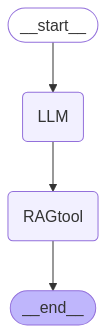

In [19]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [20]:
inputs = {"messages": ["Tell me about Firebase studio "]}

In [28]:
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

['Tell me about Firebase studio ', 'Firebase console (formerly Firebase Studio) is a web-based UI for managing Firebase projects.  It provides tools to view data, configure settings, and monitor app performance.']
Output from node 'LLM':
---
{'messages': ['Tell me about Firebase studio ', 'Firebase console (formerly Firebase Studio) is a web-based UI for managing Firebase projects.  It provides tools to view data, configure settings, and monitor app performance.', 'Web-based UI for managing Firebase projects.']}

---

Output from node 'RAGtool':
---
Firebase Studio targets developers and teams invested in the Firebase ecosystem, is particularly well-suited for solo developers, small to medium-sized teams, and is cloud-based.

---



In [22]:
"""
Putting It All Together:
The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

Must be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

messages: Annotated[Sequence[BaseMessage], operator.add]

"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]
"""

'\nPutting It All Together:\nThe line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:\n\nMust be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).\n\nmessages: Annotated[Sequence[BaseMessage], operator.add]\n\n"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]\n'

In [23]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [24]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [25]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [26]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [27]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [firebase studio, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [29]:
template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: "Tell me about Firebase studio "
    The output should be formatted as a JSON instance that conforms to the JSON schema below.

    As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
    the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

    Here is the output schema:
    ```
    {"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
        """

In [30]:
state={"messages": ["Tell me about firebase studio"]}

In [31]:
# testing function1
function_1(state)

Tell me about firebase studio
Topic='firebase studio' Reasoning='The user explicitly asks about Firebase Studio.'


{'messages': ['firebase studio']}

In [32]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [34]:
function_2({'messages': ['firebase']})

-> Calling RAG ->
firebase
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


{'messages': ['Firebase has grown into a comprehensive platform and has become a go-to platform for mobile and web developers.  It was acquired by Google.']}

In [35]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [36]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [37]:
from langgraph.graph import StateGraph,END

workflow1 = StateGraph(AgentState) ### StateGraph with AgentState

workflow1.add_node("agent", function_1)
workflow1.add_node("RAG", function_2)
workflow1.add_node("LLM", function_3)

workflow1.set_entry_point("agent")

workflow1.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow1.add_edge("RAG",END)
workflow1.add_edge("LLM",END)

app1=workflow1.compile()

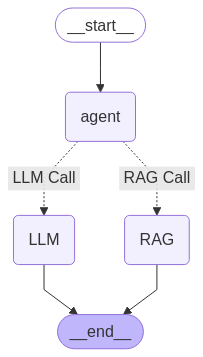

In [39]:
from IPython.display import Image, display

try:
    display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [42]:
inputs = {"messages": ["Tell me about firebase studio need for"]}
output = app1.invoke(inputs)

Tell me about firebase studio need for
Topic='firebase studio' Reasoning='The user is asking about the need for Firebase Studio.'
-> Router ->
firebase studio
-> Calling LLM ->


In [43]:
output

{'messages': ['Tell me about firebase studio need for',
  'firebase studio',
  "Firebase Studio isn't a real product.  There *is* **Firebase console**, which is probably what you're thinking of.  The Firebase console is the web-based interface used to manage and administer your Firebase projects.  Here's why you need it:\n\n* **Centralized Project Management:**  It's the central hub for all your Firebase projects. You can create new projects, manage project settings, monitor usage, and access all the different Firebase services.\n\n* **Real-time Database Management:** If you're using Firebase's real-time database, the console lets you browse data, edit it directly, and monitor activity.  This is invaluable for debugging and understanding your data structure.\n\n* **Firestore Management:**  Similar to the Realtime Database, the console provides tools for managing your Firestore database, including browsing documents, collections, and indexes.\n\n* **Authentication Management:** You can 

In [40]:
inputs = {"messages": ["Tell me about first prime minister of india?"]}
output = app1.invoke(inputs)

Tell me about first prime minister of india?
Topic='Not Related' Reasoning='The query asks about the first prime minister of India, which has no relation to Firebase Studio.'
-> Router ->
Not Related
-> Calling LLM ->


In [41]:
output

{'messages': ['Tell me about first prime minister of india?',
  'Not Related',
  'Jawaharlal Nehru was the first Prime Minister of India. He served from 15 August 1947, when India gained independence from British rule, until his death on 27 May 1964.  He was a central figure in the Indian independence movement and played a key role in shaping the modern Indian nation-state.  He is often referred to as Pandit Nehru.']}